# $C_{h}$ Models & Barcode Collapsing

Note, this was run with [this version](https://github.com/matsengrp/multidms/tree/326b036602d58f071c61372f14215d195dee23a3) of `multidms`

**Set the visible devices for GPU training**

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms

In [3]:
OUTDIR = "results/ch_collapsed_barcodes"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

**Read in the dms data and list all available experimental conditions**

In [4]:
func_score_df = pd.read_csv("prepped_func_scores.csv").fillna("")
func_score_df

,func_score,aa_substitutions,condition
0,-0.9244,R214G N439- A846H L1244-,Delta-1
1,0.4364,L10V G75D Y449N R682W A829S A1020D V1228E,Delta-1
2,-1.8556,P25S Y365H A771N S813P,Delta-1
3,-0.0470,R681S,Delta-1
4,1.2236,V70N S98G V143I,Delta-1
...,...,...,...
999050,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2-2
999051,-0.7129,P82S S112T D138T K1038N,Omicron_BA2-2
999052,-0.8500,L179P A222T G261H N405D,Omicron_BA2-2
999053,-2.3933,S27F G413E,Omicron_BA2-2


In [5]:
func_score_df.condition.unique()

array(['Delta-1', 'Delta-2', 'Delta-3', 'Delta-4', 'Omicron_BA1-1',
       'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2'],
      dtype=object)

## Generate Replicate Datasets

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [6]:
datasets = []

**Choose the libraries you would like in each of the two replicates**

In [7]:
rep1_name_map = {
    "Delta-2":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

**Initialize replicate `MultiDmsData` objects**

In [8]:
for rep_fsdf in [fs_rep1, fs_rep2]:       

    start = time.time()

    # initialize data object
    data = multidms.MultiDmsData(
        rep_fsdf,
        collapse_identical_variants="mean",
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,
        reference="Omicron_BA1",
        assert_site_integrity=False,
        verbose=True,
        nb_workers=8 
    )

    end = time.time()
    prep_time = round(end-start)
    print(f"Finished, time: {prep_time}")

    datasets.append(data)

inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 41
inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 40


**Change the datasets colors - the only mutible thing about `MultiDmsData` Objects**

In [9]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040', 
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
# cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
cc = {con:col for con, col in zip(conditions, palette)}


for data in datasets:
    data.condition_colors = cc

In [11]:
models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))

In [12]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9733555409201907, 0.8280141208921765, 0.769...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
1,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9632855593783072, 0.8125650438953164, 0.746...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
2,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9710215537922314, 0.8282119836919564, 0.768...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
3,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9681033233951882, 0.8144748418296023, 0.750...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
4,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9857248012386187, 0.8392299475448087, 0.781...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
5,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9772368335591555, 0.8210960572132471, 0.767...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
6,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.0077470996595188, 0.8581141011300257, 0.802...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
7,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9976864788836723, 0.8394673062243602, 0.786...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
8,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.0662709917105295, 0.908607495860237, 0.8530...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
9,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.047649042817643, 0.9012415576140917, 0.8433...",<multidms.model.MultiDmsModel object at 0x7f8f...,1


In [13]:
# models = pd.DataFrame()
fit_iter = 0
# shrinkage_sweep = [1e-07, 1e-06, 1e-05, 2e-05, 5e-05, 0.0001, 0.0005, 0.001]
shrinkage_sweep = [0.001]

for lasso in shrinkage_sweep:
    for replicate, dataset in enumerate(datasets):

        fit_params = {
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Softplus",
            'warmup_beta':False,
            'gamma_corrected':False,
            'conditional_c': True,
            'λ_lasso_shift':lasso,
            'λ_ridge_beta':0,
            'λ_ridge_shift':0,
#             'λ_ridge_gamma':1e-3,
            'tol':1e-6,
            'save_model_at':[20000],
            'num_training_steps': 20,
            'iterations_per_step':1000
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(dataset, **fit_params)
        model['replicate'] = replicate
        models = pd.concat([models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/10! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        

    pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f8f19efeb50>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 20,
 'output_activation': 'Softplus',
 'save_model_at': [20000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 0.001,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/20, Loss: 1.0958831156087332, Time: 23 Seconds
training_step 1/20, Loss: 0.9790431126149368, Time: 17 Seconds
training_step 2/20, Loss: 0.9521739319519145, Time: 17 Seconds
training_step 3/20, Loss: 0.939571608285597, Time: 17 Seconds
training_step 4/20, Loss: 0.9325121529279837, Time: 17 Seconds
training_step 5/20, Loss: 0.9281210079155373, Time: 17 Seconds
tra

In [14]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,replicate
0,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9733555409201907, 0.8280141208921765, 0.769...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
1,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.0,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9632855593783072, 0.8125650438953164, 0.746...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
2,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9710215537922314, 0.8282119836919564, 0.768...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
3,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.000001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9681033233951882, 0.8144748418296023, 0.750...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
4,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9857248012386187, 0.8392299475448087, 0.781...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
5,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00001,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9772368335591555, 0.8210960572132471, 0.767...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
6,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.0077470996595188, 0.8581141011300257, 0.802...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
7,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00002,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[0.9976864788836723, 0.8394673062243602, 0.786...",<multidms.model.MultiDmsModel object at 0x7f8f...,1
8,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.0662709917105295, 0.908607495860237, 0.8530...",<multidms.model.MultiDmsModel object at 0x7f8f...,0
9,<multidms.data.MultiDmsData object at 0x7f8f1e...,1,0.00005,0,0,0,0,Sigmoid,Softplus,False,...,0.0,False,0.000001,20,1000,[20000],0,"[1.047649042817643, 0.9012415576140917, 0.8433...",<multidms.model.MultiDmsModel object at 0x7f8f...,1


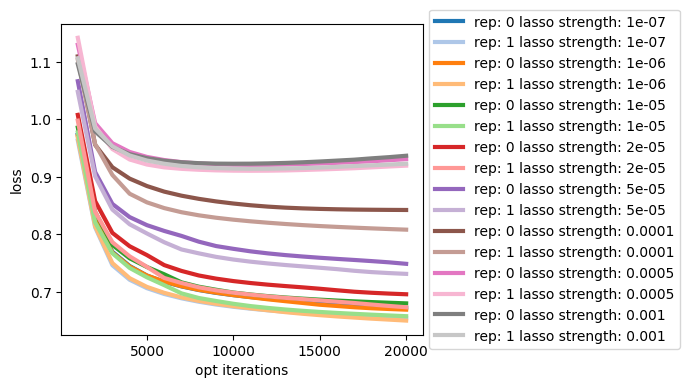

In [15]:
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[7,4])
for i, (model, model_row) in enumerate(models.iterrows()):
    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[i],
        lw=3,
        label=f"rep: {model_row.replicate} lasso strength: {model_row.λ_lasso_shift}"
    )

ax.set_ylabel("loss")
ax.set_xlabel("opt iterations")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [16]:
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

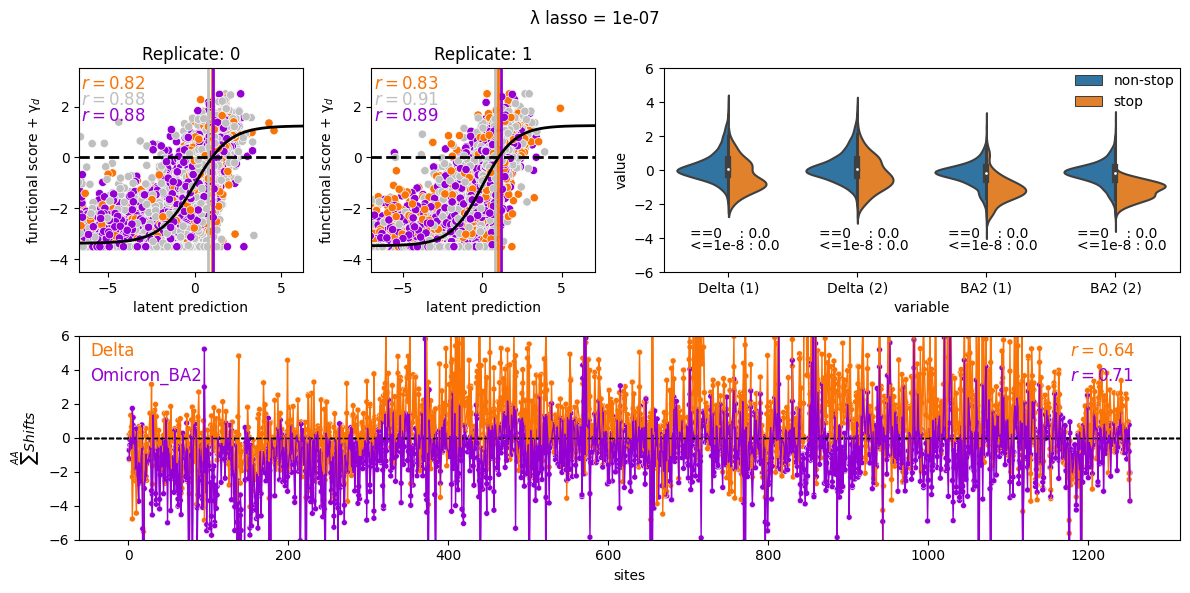

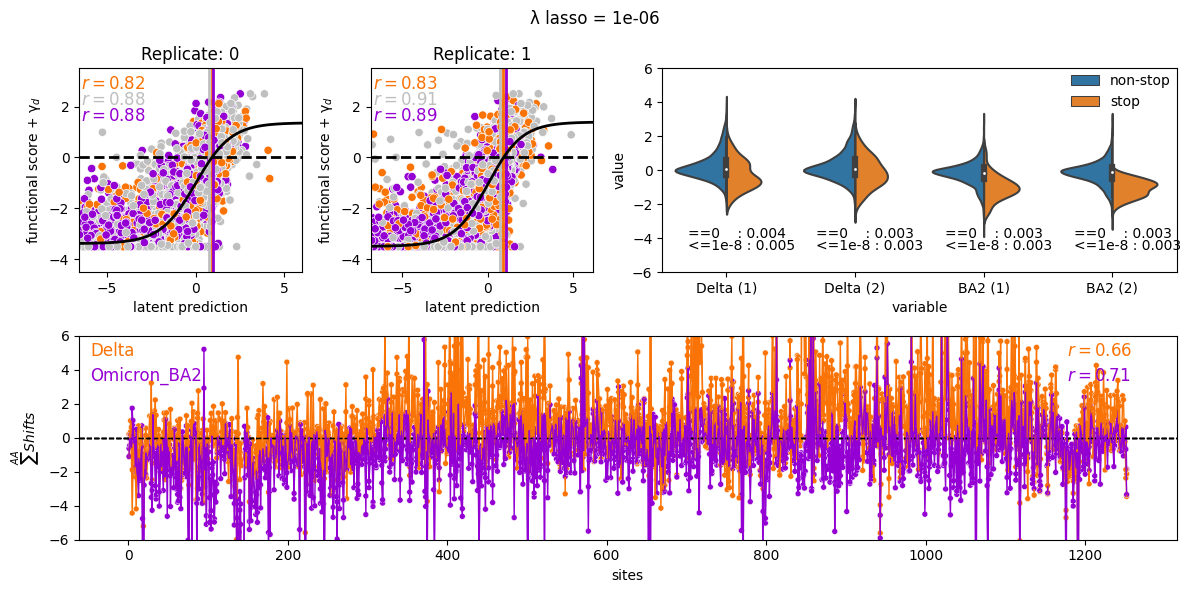

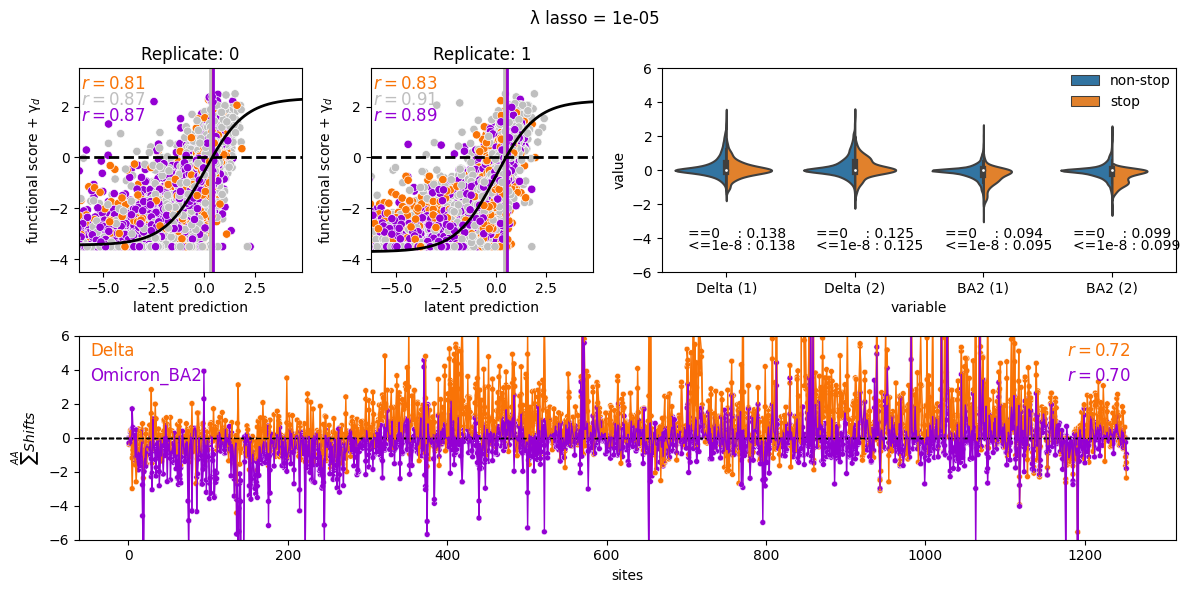

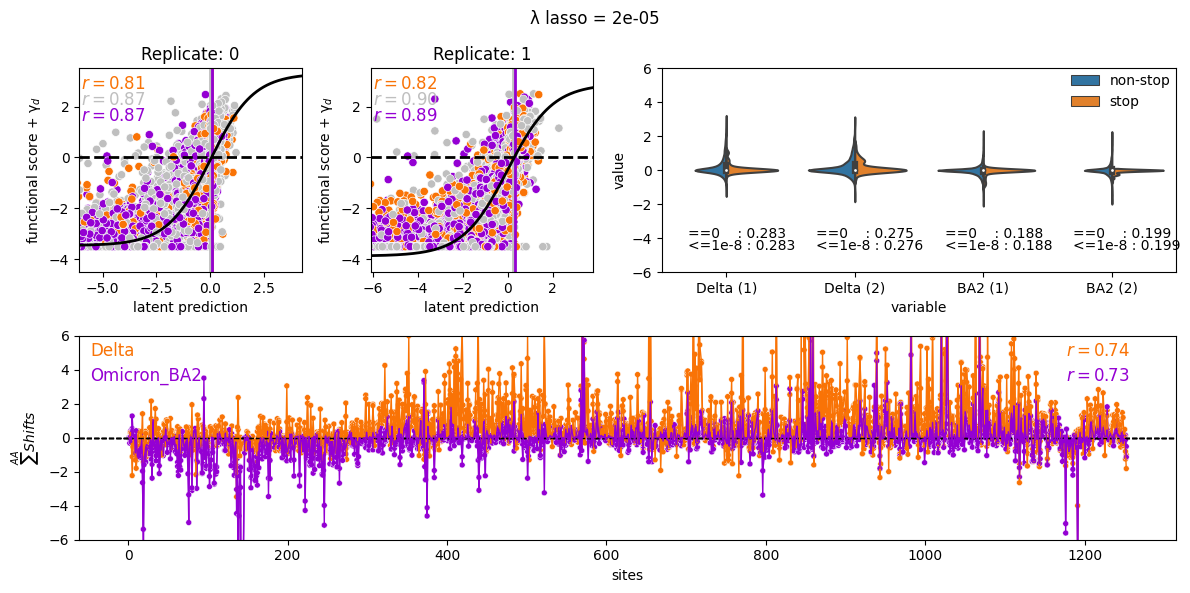

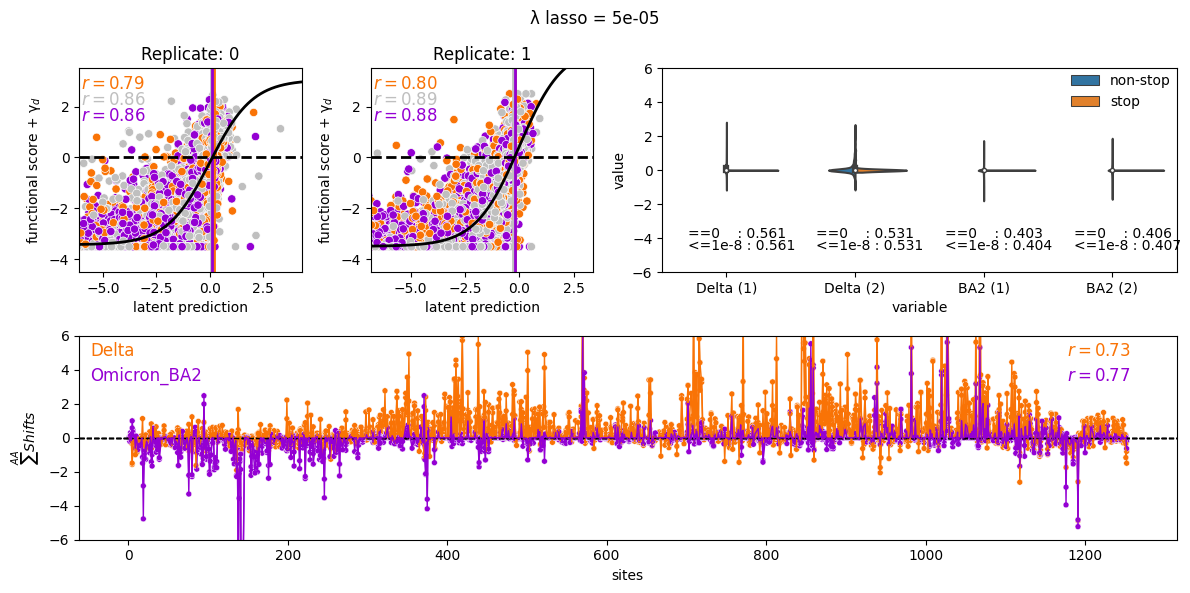

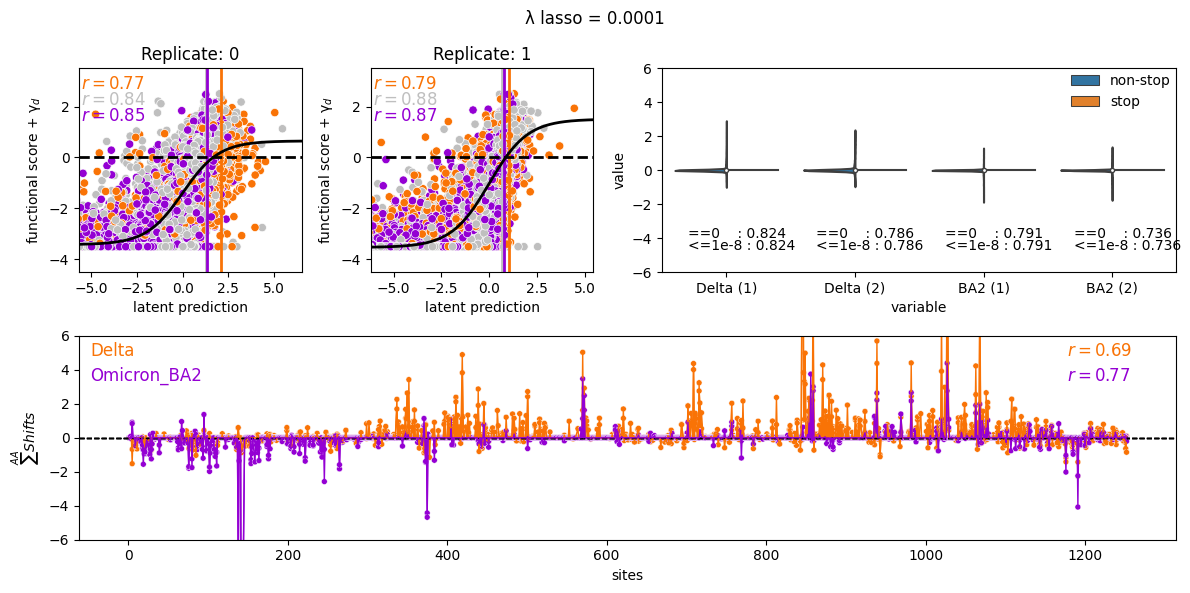

/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


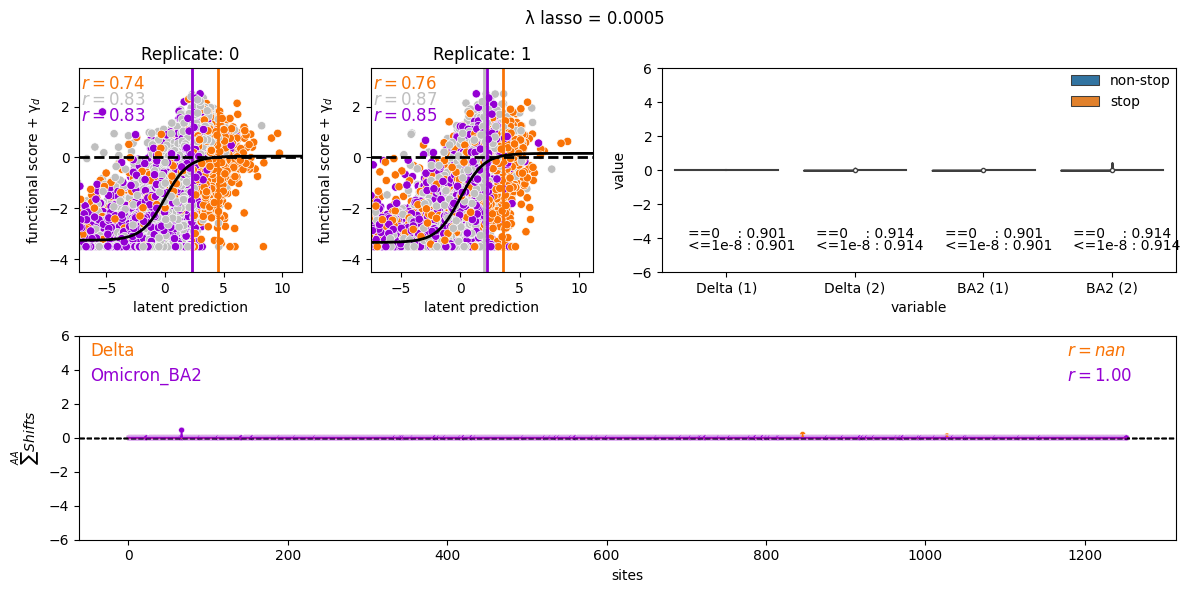

/home/jgallowa/miniconda3/envs/multidms/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


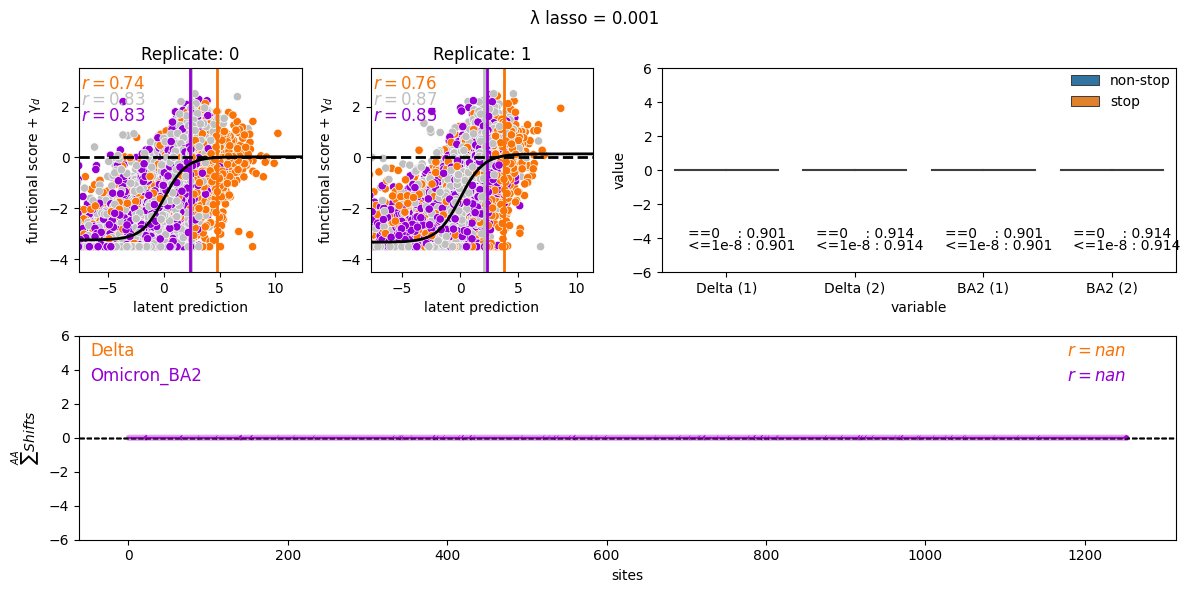

In [17]:
for i, (lasso, lasso_replicates) in enumerate(models.groupby("λ_lasso_shift")):
#     if lasso != 2e-5: continue
    i=0
    fig, ax = plt.subplot_mosaic(
        """
        01DD
        SSSS
        """,
        figsize=[12,6]
    )
    ax[f"S"].set_ylim([-6, 6])
    ax[f"D"].set_ylim([-6, 6])
    
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        replicate = row.replicate
        model = row.model_20000
        fit_dict[f"{replicate}"] = model
        
        # epistasis and accuracy
        model.plot_epistasis(show=False, ax=ax[str(replicate)], sample=0.1, legend=False)
        ax[str(replicate)].set_xlabel("latent prediction")
        ax[str(replicate)].set_title(f"Replicate: {replicate}")
        var_df = model.variants_df
        
        for b, cond in enumerate(model.data.conditions):
            var_df_cond = var_df.query(f"condition == @cond")
            corr = pearsonr(
                var_df_cond["predicted_func_score"], 
                var_df_cond["corrected_func_score"] 
            )[0]
            ax[str(replicate)].annotate(
                f"$r = {corr:.2f}$", 
                (0.01, (0.90 - (b*0.08))), 
                xycoords="axes fraction", 
                fontsize=12,
                c = model.data.condition_colors[cond]
            )
            
            if cond == model.data.reference: continue
            model.plot_shifts_by_site(
                cond, 
                show=False, 
                agg_func=onp.sum, 
                times_seen_threshold=3, 
                ax=ax[f"S"], 
                lw=1
            )
    muts_df_outer = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="outer")
    muts_df_inner = muts_df_outer.dropna()
    for b, cond in enumerate(model.data.conditions):
        if cond == model.data.reference: continue 
        corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])[0]
        ax[f"S"].annotate(
            f"$r = {corr:.2f}$", 
            (0.9, (0.9 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
        ax[f"S"].annotate(
            cond, 
            (0.01, (0.90 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
    ax[f"S"].set_ylabel("$\sum^{AA} Shifts$")
    muts_df_outer = muts_df_outer[
        [c for c in muts_df_outer.columns if "S_" in c and "avg" not in c]
    ]
    muts_df_outer.rename(
        {
            "0_S_Omicron_BA2":"BA2 (1)", 
            "1_S_Omicron_BA2":"BA2 (2)",
            "0_S_Delta":"Delta (1)",
            "1_S_Delta":"Delta (2)"
        },
        axis=1,
        inplace=True
    )
    muts_df_outer = muts_df_outer.assign(
        is_stop=[
            "stop" if "*" in m else "non-stop" 
            for m in muts_df_outer.index.values
        ]
    )
    melted_mut_df = pd.melt(muts_df_outer.reset_index(), id_vars=["mutation", "is_stop"])
    sns.violinplot(
        melted_mut_df, 
        x="variable", 
        y="value", 
        hue="is_stop", 
        ax = ax[f"D"],
        split=True
    )

    ax[f"D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)

        
    for os, (cond, cond_df) in enumerate(melted_mut_df.groupby("variable")):
        exact_sparsity = len(cond_df[cond_df['value'] == 0]) / len(cond_df)
        close_sparsity = len(cond_df[onp.isclose(cond_df['value'], 0)]) / len(cond_df)
        
        ax[f"D"].annotate(f"==0    : {round(exact_sparsity, 3)}", (os-0.3, -4))
        ax[f"D"].annotate(f"<=1e-8 : {round(close_sparsity, 3)}", (os-0.3, -4.7))
        
    
    ax["D"].legend(bbox_to_anchor=(1.00, 1), borderaxespad=0, frameon=False)
    
    fig.suptitle(f"λ lasso = {lasso}")
    plt.tight_layout()
    fig.savefig(f"ch-nogamma-summary-{lasso}.pdf")
    plt.show()